In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.constants as cst
import astropy.units as u
from heapq import nsmallest
from scipy.signal import find_peaks
from functions import vac2air_ciddor
from scipy.interpolate import interp1d
from lmfit.models import VoigtModel
from edibles.utils.voigt_profile import voigt_absorption_line
from lmfit import Model
from edibles.utils.ContinuumFitter import ContinuumFitter

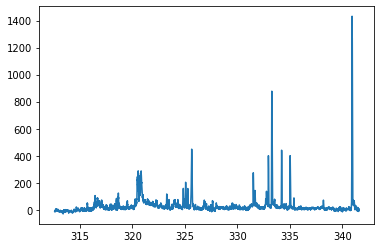

In [2]:
acenap = np.loadtxt("Phenanthrene.dat", skiprows=1).transpose()
#np.set_printoptions(threshold=np.inf)
#print(methnap)
plt.plot(acenap[0], acenap[1])
plt.show()
data=acenap

datamol = data

datamol[0,:]=vac2air_ciddor(10.0*data[0,:])


In [3]:
cf1 = ContinuumFitter(datamol[0,:], datamol[1,:])
cf11, pts = cf1.SplineManualAnchor()


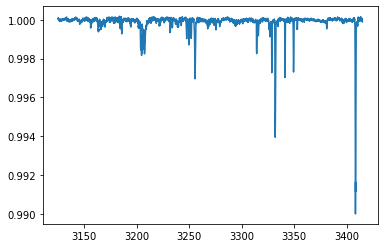

In [4]:

datamol[1,:]=1-0.01*(data[1,:]-(cf11(datamol[0,:])))/(np.max(data[1,:])-cf11(datamol[0, data[1,:] == np.max(data[1,:])]))

plt.plot(datamol[0,:], datamol[1,:])

In [5]:
cf2 = ContinuumFitter(datamol[0,:], datamol[1,:])
cf22 = cf2.SelectPoints(n=100, y_message=None)[:,0]

peaks = np.reshape(cf22, (int(cf22.size/2),2))
print(peaks)

[[3153.13684493 3158.65545353]
 [3162.31453068 3172.66191976]
 [3183.2494464  3187.74810991]
 [3191.88706401 3196.53588893]
 [3199.89503962 3205.1738046 ]
 [3205.47372874 3208.95274862]
 [3228.64786254 3232.4569975 ]
 [3236.53586388 3241.99438025]
 [3245.47369807 3248.55271723]
 [3252.33195861 3258.42021386]
 [3265.48841977 3270.46735554]
 [3277.87547383 3282.49430021]
 [3312.57664895 3317.96507708]
 [3324.44352716 3329.69209005]
 [3331.28168501 3335.36084546]
 [3339.76952168 3343.30861937]
 [3347.53754096 3350.65694533]
 [3352.0365934  3355.5756905 ]
 [3377.9497786  3383.19863767]
 [3406.82239814 3413.15097901]]


In [6]:
# Calculating standard deviation to calculate the noise in the data
sdar = datamol

for i3 in range(peaks.shape[0]):
    sdar = np.delete(sdar, np.logical_and(sdar[0,:]>=peaks[i3,0], sdar[0,:]<=peaks[i3,1]),1)
    
sd = np.std(sdar[1,:])
print(sd)

0.00010072233310100311


In [7]:
# Function for voigt fitting the peaks of entire spectra
# input parameters: file_name, array of start & end points of peak, standard deviation


def voigtmultipeak(fdata, rang, sd):
    ar2={}
    No_Peaks=rang.shape[0]
    for i2 in range(No_Peaks):
        xfit_m = fdata[0, np.logical_and(fdata[0,:]>=rang[i2,0], fdata[0,:]<=rang[i2,1])]
        yfit_m = 1 - fdata[1, np.logical_and(fdata[0,:]>=rang[i2,0], fdata[0,:]<=rang[i2,1])]
        mod = VoigtModel()
        par = mod.guess(yfit_m, x=xfit_m)
        res = mod.fit(yfit_m, par, weights=1/sd, x=xfit_m)
        plt.plot(xfit_m, 1-res.best_fit, label='Fitted peak'+str(i2+1))
    
        cenkey = 'Center' + str(i2+1)
        fwhmkey = 'Fwhm' + str(i2+1)
        chisqkey = 'ChiSqr' + str(i2+1)
        rchisqkey = 'RedChiSqr' + str(i2+1)
        ar2.update({cenkey: res.params['center'].value})
        ar2.update({fwhmkey: res.params['fwhm'].value})
    ar2.update({'ChiSq': res.chisqr})
    ar2.update({'RedChiSq': res.redchi})
        
    return ar2

{'Center1': 3156.1407767394708, 'Fwhm1': 0.5981565306547358, 'Center2': 3164.7332258928027, 'Fwhm2': 7.339012997435326, 'Center3': 3185.6322883658286, 'Fwhm3': 0.621776006821817, 'Center4': 3194.1897047770735, 'Fwhm4': 0.5793947891245825, 'Center5': 3204.265048583492, 'Fwhm5': 1.7407722528490257, 'Center6': 3206.9858575706007, 'Fwhm6': 3.1845485194596965, 'Center7': 3231.8484324765204, 'Fwhm7': 0.428295384876588, 'Center8': 3239.2068197633957, 'Fwhm8': 1.5114345953000825, 'Center9': 3247.5413854670674, 'Fwhm9': 0.529735661467542, 'Center10': 3255.548350785755, 'Fwhm10': 0.7664287754233581, 'Center11': 3267.6991888938423, 'Fwhm11': 1.9248478877436281, 'Center12': 3279.0721350889507, 'Fwhm12': 1.2794017177137524, 'Center13': 3314.2179312537082, 'Fwhm13': 0.4748646027498165, 'Center14': 3328.6522440683116, 'Fwhm14': 0.38624507105566347, 'Center15': 3331.9052679011666, 'Fwhm15': 0.511393339896081, 'Center16': 3341.2056551066685, 'Fwhm16': 0.37183965056056756, 'Center17': 3349.3710742092435

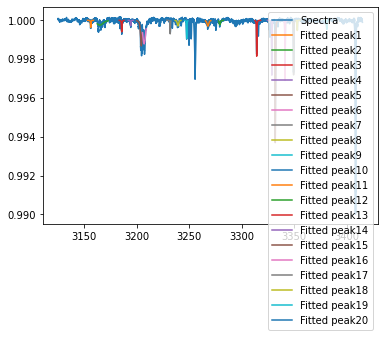

In [8]:
plt.plot(datamol[0,:],datamol[1,:], label='Spectra')
pk_fit_par = voigtmultipeak(datamol, peaks, sd)
plt.legend()
print(pk_fit_par)

In [9]:
stack_par = np.zeros((peaks.shape[0],2))

for i4 in range(peaks.shape[0]):
    p1 = 'Center' + str(i4+1)
    p2 = 'Fwhm' + str(i4+1)
    stack_par[i4,0] = pk_fit_par[p1]
    stack_par[i4,1] = pk_fit_par[p2]
    
print(stack_par)

[[3.15614078e+03 5.98156531e-01]
 [3.16473323e+03 7.33901300e+00]
 [3.18563229e+03 6.21776007e-01]
 [3.19418970e+03 5.79394789e-01]
 [3.20426505e+03 1.74077225e+00]
 [3.20698586e+03 3.18454852e+00]
 [3.23184843e+03 4.28295385e-01]
 [3.23920682e+03 1.51143460e+00]
 [3.24754139e+03 5.29735661e-01]
 [3.25554835e+03 7.66428775e-01]
 [3.26769919e+03 1.92484789e+00]
 [3.27907214e+03 1.27940172e+00]
 [3.31421793e+03 4.74864603e-01]
 [3.32865224e+03 3.86245071e-01]
 [3.33190527e+03 5.11393340e-01]
 [3.34120566e+03 3.71839651e-01]
 [3.34937107e+03 4.67816504e-01]
 [3.35289217e+03 3.64738075e-01]
 [3.38094590e+03 5.26929709e-01]
 [3.40837093e+03 5.05967551e-01]]


In [10]:
#Function for Spectral stacking, which takes in the input as filename and array having info about start and end points of peak. 

def spectral_stacker_voigt(fdata,peaks):
    
    No_Peaks = peaks.shape[0]
    fpeaks = np.empty(shape=No_Peaks, dtype=object)
    
    ffig, faxs = plt.subplots(3, 2, figsize=(12,15))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    faxs[0,0].plot(fdata[0, :], fdata[1, :])
    faxs[0,0].set_title('Lab Spectrum')
    faxs[0,0].set(xlabel = 'Wavelength (Å)', ylabel = 'Relative intensity')
    
    
    # Creating separate arrays for each absorption in the spectra
    for i1 in range(No_Peaks):
        fpeaks[i1] = fdata[:,np.logical_and(fdata[0,:]>=peaks[i1,0]-2*peaks[i1,1], fdata[0,:]<=peaks[i1,0]+2*peaks[i1,1])]
        p = 'Peak'+str(i1+1)
        faxs[0,1].plot(fpeaks[i1][0,:], fpeaks[i1][1,:], label=p)
    faxs[0,1].set_title('Peaks')
    faxs[0,1].set(xlabel = 'Wavelength (Å)', ylabel = 'Relative intensity')
    faxs[0,1].legend()
    
    fDshft = fpeaks
    for j1 in range (No_Peaks):
        fDshft[j1][0,:] = fpeaks[j1][0,:]-peaks[j1,0]
        fDshft[j1][1,:] = fpeaks[j1][1,:]
        shp = 'Peak ' + str(j1+1)
        faxs[1, 0].plot(fDshft[j1][0,:], fDshft[j1][1,:], label = shp)
        
    faxs[1,0].set_title('Spectrum with peaks shifted')
    faxs[1,0].set(xlabel = 'Relative Wavelength (Å) (shifted by peak)', ylabel = 'Relative intensity')
    faxs[1,0].legend()
    
    fpoints = fDshft[0].shape[1]
    fstart = np.min(fDshft[0][0,:])
    fend = np.max(fDshft[0][0,:])
    for k1 in range(No_Peaks):
        if fDshft[k1].shape[1]>fpoints:
            fpoints = fDshft[k1].shape[1]
        if np.min(fDshft[k1][0,:]) > fstart:
            fstart = np.min(fDshft[k1][0,:])
        if np.max(fDshft[k1][0,:]) < fend:
            fend = np.max(fDshft[k1][0,:])
    fwavelength = np.linspace(fstart, fend, num = fpoints)  
    
            
    fitpn = np.empty(shape=No_Peaks, dtype=object)  
    for l1 in range(No_Peaks):
        fitpn[l1] = interp1d(fDshft[l1][0,:], fDshft[l1][1,:])
        
        
    ffin = np.zeros((2, fpoints))
    ffin[0,:] = fwavelength
    
    for m1 in range(No_Peaks):
        ffin[1,:] = ffin[1,:]+(fitpn[m1](fwavelength)/No_Peaks)
        pk1 = 'Peak' +str(m1+1)
        faxs[1,1].plot(fwavelength, fitpn[m1](fwavelength), label=pk1)         
        faxs[2,0].plot(fwavelength, fitpn[m1](fwavelength),label=pk1)
    faxs[1,1].set_title('Interpolated Peaks having same widths')
    faxs[1,1].set(xlabel = 'Relative Wavelength (Å) (shifted by peak)', ylabel = 'Relative intensity')
    faxs[1,1].legend()
    faxs[2,0].set_title('Interpolated Peaks with the stacked peak')
    faxs[2,0].set(xlabel = 'Relative Wavelength (Å) (shifted by peak)', ylabel = 'Relative intensity')
    faxs[2,0].legend()
        
    faxs[2,0].plot(ffin[0,:], ffin[1,:], label='Stacked spectra')
    faxs[2,0].legend()
    faxs[2,1].plot(ffin[0,:], ffin[1,:], label = 'Final Stacked peak')
    faxs[2,1].set_title('Only Stacked peak')
    faxs[2,1].set(xlabel = 'Relative Wavelength (Å)(shifted by peak)', ylabel = 'Relative intensity')
    faxs[2,1].legend()
    plt.subplots_adjust(hspace=0.3, wspace=0.2)

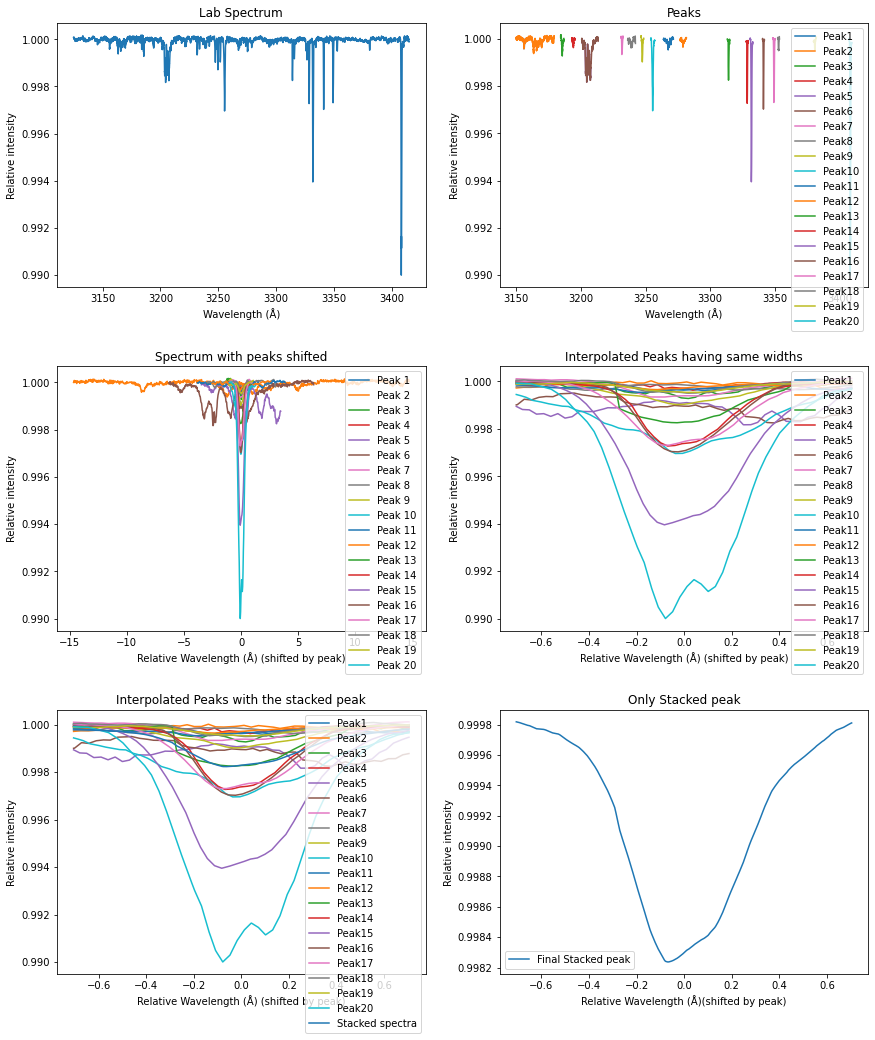

In [11]:
spectral_stacker_voigt(datamol, stack_par)